**The action space here are the variables themselves. At each step we use the action space to select top N variables and then use BOHM to choose the best one of these.**

In [25]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle
from itertools import combinations
from scipy.special import comb

import random

from matplotlib2tikz import save as tikz_save

In [11]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False
        for literal in list(literal_clauseNum.keys()):
            if literal in literal_boolen:
                continue

            opposite_literal = switch_literal(literal)
            if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
                # If it doesn't exist or it does but it doesn't have to satisfy any clauses
                if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                    # LITERAL IS A PURE LITERAL
                    keep_updating = True
                    literal_boolen[literal] = True

                    # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                    pairs_to_delete = []
                    for clauseNums_with_literal in literal_clauseNum[literal]:
                        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

            #         print(pairs_to_delete)

                    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                        if clauseNums_with_literal in clauseNum_clause:
                            del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen



def bohm(literal_clauseNum, clauseNum_clause):
    """
    See Heuristics folder. Lexicographic order of the vector (H1(x), H2(x), ..., Hn(x)) means we first choose highest H1(x)
    variable. When tied we then choose amongst tied variable highest H2 variable. When tied then H3 and so on.
    
    We've had to manage edge cases here but don't mention that in report. Only give formula from paper
    """
    pos_literal_count = defaultdict(lambda: [0, 0, 0])  # This default initialisation only works for 3 SAT
    neg_literal_count = defaultdict(lambda: [0, 0, 0])
    
    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                neg_literal_count[literal][len(clause)-1] += 1
        else:
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                pos_literal_count[literal][len(clause)-1] += 1
                
    final_count = []
    # Sometimes we only have negative literals left. So then we just use those
    for literal, pos_counts in (pos_literal_count.items() or neg_literal_count.items()):
        other_literal = switch_literal(literal)
        
        if literal.startswith('-'):
            # pos_literal_counts is empty. So literal and pos_counts actually are neg_literal_counts
            neg_counts = pos_literal_count[other_literal]
        else:
            # pos_literal_counts isn't empty. So continue as normal
            neg_counts = neg_literal_count[other_literal]
        
        final_count.append(([max(p, n) + 2 * min(p, n) for p, n in zip(pos_counts, neg_counts)], literal))
            
    final_count.sort(reverse=True)
    score_vector, literal = final_count[0]
    other_literal = switch_literal(literal)
    
    if literal.startswith('-'):
        neg_literal = literal
        pos_literal = other_literal
    else:
        neg_literal = other_literal
        pos_literal = literal
    
    # Since the score for positive and negative literal is the same, choose one which the highest overall score
    if sum(pos_literal_count[pos_literal]) >= sum(neg_literal_count[neg_literal]):
        literal = pos_literal
    else:
        literal = neg_literal
    
    return literal, score_vector
    

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

In [12]:
# Methods that are used by the Env class to get state features

def number_of_clauses(literal_clauseNum):
    """ Returns the number of clauses each of the literal is present in """
    ans = np.zeros(actions)
    for literal, clauseNums in literal_clauseNum.items():
        ans[LIT_IDX[literal]] = len(clauseNums)
    return ans


def number_of_horn_clauses(clauseNum_clause):
    """ Returns the number of horn clauses each literal is present in """
    ans = np.zeros(actions)
    for clause in clauseNum_clause.values():
        if len(clause) == 0:
            continue
        pos_literals = list(filter(lambda x: not x.startswith('-'), clause))
        if len(pos_literals) == 1:
            ans[LIT_IDX[pos_literals[0]]] += 1
            
    return ans
        
def pos_neg_ratio(literal_clauseNum):
    ans = np.zeros(actions)
    
    for literal, clauseNums in literal_clauseNum.items():
        opposite_literal = switch_literal(literal)
        if opposite_literal in literal_clauseNum and len(literal_clauseNum[opposite_literal]) > 0:
            ratio = len(clauseNums) / len(literal_clauseNum[opposite_literal])
        else:
            ratio = len(clauseNums)
            
        ans[LIT_IDX[literal]] = ratio
        
    return ans


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in rows and clauses in columns.
    See Features_2 PDF file.
    """
    
    clauseNum_index_mapping = {}
    
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
        
    if len(clauseNum_clause) == 0:
        return np.zeros((len(LIT_IDX), 1))
    
    graph = np.zeros((len(LIT_IDX), len(clauseNum_index_mapping)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[LIT_IDX[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return graph


def VIG(literal_clauseNum, clauseNum_clause):
    """
    Variable incidence graph.
    """
    if len(clauseNum_clause) == 0:
        return np.zeros((actions, actions))
    
    graph = np.zeros((actions, actions))
    
    for clause in clauseNum_clause.values():
        if len(clause) < 2:
            continue
        for x, y in combinations(clause, 2):
            w = 1 / (comb(len(clause), 2))  # Try combinations with replacement to add self-loops
            graph[LIT_IDX[x]][LIT_IDX[y]] = w
            graph[LIT_IDX[y]][LIT_IDX[x]] = w
            
    return graph

In [13]:
# env = Env('../Tests/SATLIB_20/uf20-026.cnf')
# print(env.reset())
# while True:
#     _, _, done = env.step(4)
#     if done:
#         break
#     print(env.get_state())
#     a, b, c = env.state
#     print(jw_2(a, b))

In [14]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses = number_of_clauses(literal_clauseNum)
        num_horn_clauses = number_of_horn_clauses(clauseNum_clause)
        
        pn_ratio = pos_neg_ratio(literal_clauseNum)
        
        vig_graph = VIG(literal_clauseNum, clauseNum_clause)
        vig_mean, vig_var = np.mean(vig_graph, axis=0), np.var(vig_graph, axis=0)
        
        cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
        cvig_mean, cvig_var = np.mean(cvig_graph, axis=1), np.var(cvig_graph, axis=1)
        
        state_matrix = list(zip(num_clauses, num_horn_clauses, pn_ratio, vig_var, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses, cvig_mean, cvig_var))
#         state_matrix = list(zip(num_clauses, num_horn_clauses))
        return np.array(state_matrix)  # Returns a 2D array of the state matrix
    
        
        
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses_start = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_start += 1
            else:
                # This is reached when we reached an UNSAT state in previous step and popped off another UNSAT from the stack
                isEmpty = len(self.stack) == 0
                if not isEmpty:
                    self.state = self.stack.pop()
                return None, -1, isEmpty
        
        literal = action
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
            
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
        # Check that setting chosen to False hasn't made any empty clauses
        valid = True
        for clause in clauseNum_clause_F.values():
            if len(clause) == 0:
                valid = False
        
        # Add new state to stack
        if valid:
            self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        
        if clauseNum_clause_T == {} or clauseNum_clause_F == {}:  # We have satisfied
#             print("INITIAL")
            return None, 1, True
        
        
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return None, -1, isEmpty
        
        if clauseNum_clause == {}:
#             print("UNIT PROP")
            return None, 1, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
            
        if clauseNum_clause == {}:
#             print("PLE")
            return None, 1, True
        
        num_clauses_end = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_end += 1
        
        if num_clauses_start > 0:
            fraction_of_clauses_removed = (num_clauses_start - num_clauses_end)/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
                
        return None, -1 + fraction_of_clauses_removed, False

In [15]:
def DQN_make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation, literal_clauseNum):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        
        # Make q_values of unusable actions -inf
        for literal, clauseNums in literal_clauseNum.items():
            if len(clauseNums) == 0:
                idx = LIT_IDX[literal]
                q_values[idx] = -np.inf
        
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def redistribute_probability(action_prob, literal_clauseNum):
    total_gained = 0
    idx_to_increase = []
    
    for literal in LIT_IDX:  # If a literal doesn't appear in the formula, then literal_clauseNum won't have it
        clauseNums = literal_clauseNum[literal]
        if len(clauseNums) == 0:
            idx = LIT_IDX[literal]
            total_gained += action_prob[idx]
            action_prob[idx] = 0
        else:
            idx_to_increase.append(LIT_IDX[literal])
            
    per_idx_inc = total_gained / len(idx_to_increase)
    
    for idx in idx_to_increase:
        action_prob[idx] += per_idx_inc
    return action_prob

def copy_params(copy_from_est, copy_to_est):
    copy_to_est.model.set_weights(copy_from_est.model.get_weights())

In [16]:
def test(test_files, ϵ=1.0, estimator=None, num_top_actions=3, use_hybrid=False):

    total_reward, total_length, total_states, total_actions = 0, 0, [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1
        
    policy = DQN_make_epsilon_greedy_policy(estimator, ϵ, actions)
    
    for i, filepath in enumerate(test_files):
        
#         if i % 100 == 0:
#             print("Testing file", i)
        
        env = Env(filepath)
        state = env.reset()
        
        while True:
            literal_clauseNum, clauseNum_clause, _ = env.state
            
            action_prob = policy(state, literal_clauseNum)
            action_prob = redistribute_probability(action_prob, literal_clauseNum)
            
            if use_hybrid:
                # Using Hybrid approach for testing
                top_action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob, size=num_top_actions)
                action_literal_clauseNum = {IDX_LIT[idx]: literal_clauseNum[IDX_LIT[idx]] for idx in top_action_idx}
                action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
                action_idx = LIT_IDX[action]
            else:
                # Only relying on policy
                action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob)
                action = IDX_LIT[action_idx]

            _, reward, done = env.step(action)

            # Stats
            total_length += 1
            total_reward += reward
            total_actions.append(action_idx)

            if done:
                break

            state = env.get_state()

    return total_reward/len(test_files), total_length/len(test_files), np.array(total_actions) #, total_states

**Next cell is Linear method if that works best**

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

class Estimator():
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.model = SGDRegressor(learning_rate="constant", eta0=0.001, penalty='l2')
        self.model.partial_fit([self.featurize_state(np.zeros(state_space))], [0])
        self.scaler = StandardScaler()
        self.scaler.fit([self.featurize_state(np.zeros(state_space))], [np.zeros(state_space)])
    
    def featurize_state(self, state):
        # Needs to return a 1D array
        if use_poly:
            state = int(state)
            return np.array([state**i for i in range(1, poly_degree+1)])
        else:
            return np.array(state)
    
    def predict(self, state):
        ans = []
        for lit_state in state:
            state_feature = self.featurize_state(lit_state)
            
            if len(state_feature.shape) < 2:
                state_feature = np.expand_dims(state_feature, 0)
            
            state_feature = self.scaler.transform(state_feature) # Returns a 2D array
            q_val= self.model.predict(state_feature)[0]
            ans.append(q_val)
            
        return np.array(ans)
    
    def update(self, state, action_idx, reward):
        model = self.model
        state_feature = self.featurize_state(state[action_idx])
        
        if len(state_feature.shape) < 2:
            state_feature = np.expand_dims(state_feature, 0)
        
        self.scaler.partial_fit(state_feature)
        state_feature = self.scaler.transform(state_feature) # Returns a 2D array
        model.partial_fit(state_feature, [reward])
        
        return 0
    
    

def train(training_files, epsilon=0.4, epsilon_decay=0.94, discount_factor=1.0, num_top_actions=3, output_stats_every=1000):
    total_reward, total_length = [], []
    
    estimator = Estimator()
    
    curr_length = 0
    curr_reward = 0
    
    for j, filepath in enumerate(training_files):
        """ Each file in one episode """
        
        if j % output_stats_every == 0:
            part = j // output_stats_every
            epsilon_decay_j = epsilon_decay**part
            total_reward.append(curr_reward / output_stats_every)
            total_length.append(curr_length / output_stats_every)
            print(part, total_reward[-1], total_length[-1])

            curr_length = 0
            curr_reward = 0
            policy = DQN_make_epsilon_greedy_policy(estimator, epsilon*epsilon_decay_j, actions)

        env = Env(filepath)
        state = env.reset()

        while True:
            literal_clauseNum, clauseNum_clause, _ = env.state
            
            action_prob = policy(state, literal_clauseNum)
            action_prob = redistribute_probability(action_prob, literal_clauseNum)
            top_action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob, size=num_top_actions)
            
            action_literal_clauseNum = {IDX_LIT[idx]: literal_clauseNum[IDX_LIT[idx]] for idx in top_action_idx}
            action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
            action_idx = LIT_IDX[action]
            
            if len(literal_clauseNum[action]) == 0:
                print("INVALID ACTION")
            
            _, reward, done = env.step(action)

            # Stats
            curr_length += 1
            curr_reward += reward

            if done:
                td_target = reward
                estimator.update(state, action_idx, td_target)
                break

            next_state = env.get_state()

            q_values = estimator.predict(next_state)
            
            td_target = reward + discount_factor * np.max(q_values)
            current_value = estimator.predict(state)[action_idx]
            td_error = td_target - current_value

            alpha = 0.8
            update_target = current_value + alpha*td_error
            estimator.update(state, action_idx, update_target)

            state = next_state

    total_reward.append(curr_reward / output_stats_every)
    total_length.append(curr_length / output_stats_every)
    print("Last output:", total_reward[-1], total_length[-1])
    
    return total_reward, total_length, [], estimator

**Next cell is non-Linear method if that works best**

In [9]:
# from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from keras.models import Model
# from keras.optimizers import Adam
# import keras.backend as K

# from sklearn.preprocessing import StandardScaler

# class Estimator():
    
#     def __init__(self):
#         self.scaler = StandardScaler()
#         self.scaler.fit(self.featurize_state([np.zeros(state_space)]), [np.zeros(state_space)])
        
#         self.create_model()
        
#         self.model = Model(inputs=self.input, outputs=self.output)
#         self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
        
#     def create_model(self):
#         self.input = Input(shape=(state_space,))
        
#         self.h1 = Dense(16, activation=None)(self.input)
#         self.a1 = LeakyReLU()(self.h1)
#         self.norm1 = BatchNormalization()(self.a1)
        
#         self.h2 = Dense(4, activation=None)(self.a1)
#         self.a2 = LeakyReLU()(self.h2)
#         self.norm2 = BatchNormalization()(self.a2)
        
#         # We only output one value!
#         self.output = Dense(1, activation=None)(self.norm2)
        
        
#     def featurize_state(self, state):
#         # State is a batch of states
#         return np.array(state)
    
#     def predict(self, state):
#         """
#         State is a 2D array
#         """
#         if len(state.shape) == 3:
#             q_val = []
#             for state_feature in state:
#                 # state_feature is a 2D matrix from which we get all the q-values in one pass
#                 state_feature = self.featurize_state(state_feature)

#                 if len(state_feature.shape) < 2:
#                     state_feature = np.expand_dims(state_feature, 0)

#                 state_feature = self.scaler.transform(state_feature) # Returns a 2D array
#                 ans = self.model.predict(state_feature).squeeze()
#                 q_val.append(ans)
#             q_val = np.array(q_val)
            
#         else:
#             state_feature = self.featurize_state(state)

#             if len(state_feature.shape) < 2:
#                 state_feature = np.expand_dims(state_feature, 0)

#             state_feature = self.scaler.transform(state_feature) # Returns a 2D array
#             q_val = self.model.predict(state_feature).squeeze()
        
#         return q_val
    
#     def update(self, state, action_index, target):
#         """ action: action_index of the literal we chose """
#         state = self.featurize_state(state[action_index])
#         target = np.array(target)
        
#         if len(target.shape) != 2 or target.shape[1] != 1:
#             target = target.squeeze()
#             target = np.expand_dims(target, 1)
            
#         self.scaler.partial_fit(state)
#         state = self.scaler.transform(state)
#         loss = self.model.train_on_batch(state, target)
        
#         return loss


# def train(training_files, batch_size=128, discount_factor=1.0, epsilon=0.4, epsilon_decay=0.94, num_top_actions=3, output_stats_every=1000):
    
#     q_estimator = Estimator()
#     target_estimator = Estimator()
    
#     replay_memory = []
#     rewards_every_1000 = []
#     length_every_1000 = []
#     loss_every_1000 = []
    
#     # The policy we're following
#     policy = DQN_make_epsilon_greedy_policy(q_estimator, epsilon, actions)
    
#     print("Starting populating memory")
#     # Populate memory
#     for i, filepath in enumerate(training_files[:1000]):
        
#         if i % 100 == 0:
#             print('Populating', i)
        
#         env = Env(filepath)
#         state = env.reset()
        
#         while True:
#             literal_clauseNum, clauseNum_clause, _ = env.state

#             action_prob = policy(state, literal_clauseNum)
#             action_prob = redistribute_probability(action_prob, literal_clauseNum)
#             top_action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob, size=num_top_actions)
            
#             action_literal_clauseNum = {IDX_LIT[idx]: literal_clauseNum[IDX_LIT[idx]] for idx in top_action_idx}
#             action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
#             action_idx = LIT_IDX[action]
            
#             _, reward, done = env.step(action)
#             next_state = env.get_state()
#             replay_memory.append((state[action_idx], action_idx, reward, next_state, done))
#             if done:
#                 break
            
#             state = next_state
            
#     print("Starting MC training")  
#     # Make target network predict actual discounter total rewards received using MC method
#     # We know that the memory recorded is sequential. So we have episodic data
#     states_batch, action_batch, targets_batch = [], [], []
#     curr_episode_rewards = []
#     for state, action_idx, reward, next_state, done in replay_memory:
#         states_batch.append(state)
#         action_batch.append(action_idx)
#         curr_episode_rewards.append(reward)
        
#         if done:
#             # Calculate the targets from the rewards seen in episode
#             ans = list(np.cumsum(curr_episode_rewards[::-1])[::-1])  # Only works since discount factor = 1.0
#             targets_batch.extend(ans)
#             curr_episode_rewards = []
    
#     loss = 5000
#     i = 0
#     while loss > 3000:
#         i += 1
#         states_batch, action_batch, targets_batch = np.array(states_batch), np.array(action_batch), np.array(targets_batch)      
#         # Sample some of the data points. Better than giving it new data every time
#         sample_idx = np.array(random.sample(range(len(states_batch)), batch_size))
# #         if i % 100 == 0:
# #             print(loss, action_batch[sample_idx[0]], targets_batch[sample_idx[0]])
#         loss = target_estimator.update(states_batch[sample_idx], action_batch[sample_idx], targets_batch[sample_idx])
        
        
            
#     max_memory = len(replay_memory) * 10
#     print("Memory size:", max_memory)
    
#     print("Starting training")
    
#     curr_reward = 0
#     curr_length = 0
#     curr_loss = 0
    
#     for i, filepath in enumerate(training_files[1000:]):
        
#         env = Env(filepath)
#         state = env.reset()
        
#         if i % output_stats_every == 0:
#             print(i, curr_reward / output_stats_every, curr_length / output_stats_every, curr_loss / output_stats_every)
#             rewards_every_1000.append(curr_reward / output_stats_every)
#             length_every_1000.append(curr_length / output_stats_every)
#             loss_every_1000.append(curr_loss / output_stats_every)
            
#             curr_reward = 0
#             curr_length = 0
#             curr_loss = 0
            
#             # Copy model parameters over
#             copy_params(q_estimator, target_estimator)
            
#             # Make new policy
#             part = i // output_stats_every
#             print("New epsilon:", epsilon*(epsilon_decay**part))
#             policy = DQN_make_epsilon_greedy_policy(q_estimator, epsilon*(epsilon_decay**part), actions)
        
        
#         while True:
#             literal_clauseNum, clauseNum_clause, _ = env.state
            
#             action_prob = policy(state, literal_clauseNum)
#             action_prob = redistribute_probability(action_prob, literal_clauseNum)
#             top_action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob, size=num_top_actions)
            
#             action_literal_clauseNum = {IDX_LIT[idx]: literal_clauseNum[IDX_LIT[idx]] for idx in top_action_idx}
#             action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
#             action_idx = LIT_IDX[action]
            
#             _, reward, done = env.step(action)
            
#             next_state = env.get_state()
#             replay_memory.append((state[action_idx], action_idx, reward, next_state, done))
#             if len(replay_memory) > max_memory:
#                 replay_memory.pop(0)
                
#             # Update stats
#             curr_reward += reward
#             curr_length += 1
            
#             if done:
#                 break
                
#             state = next_state
        
#         # Sample a minibatch from the replay memory
#         samples = random.sample(replay_memory, batch_size)
#         states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))
        
#         # Calculate q values and targets
#         q_values_next = target_estimator.predict(next_states_batch)
#         targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)
        
#         curr_loss += q_estimator.update(states_batch, action_batch, targets_batch)
#         if i % (output_stats_every/10) == 0:
#             print(action_batch[0], targets_batch[0])
        
        
#     return rewards_every_1000, length_every_1000, loss_every_1000, q_estimator

In [39]:
use_poly = False
poly_degree = 7

numVars = 20
LITERALS = list(range(-numVars, 0))
pos_lit = list(range(1, numVars+1))
LITERALS.extend(pos_lit)
LIT_IDX = {}  # Global mapping between literal and its position in the action space
IDX_LIT = {}  # Global mapping between its position in the action space and literal

for index, var in enumerate(LITERALS):
    LIT_IDX[str(var)] = index
    IDX_LIT[index] = str(var)

actions = len(LITERALS)  # Number of actions available to use by the agent
state_space = 6          # Number of metrics for each literal

directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = list(map(lambda x: os.path.join(directory, x), os.listdir(directory)))

split = int(len(files) * 0.002)
training_files = files[:split]
# shuffle(training_files)

test_files = files[60000:60100]

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))
print()

s = time.time()
episode_reward_train, episode_length_train, losses, estimator = train(training_files, epsilon=0.3, epsilon_decay=0.95, output_stats_every=10)
e = time.time()
print("Done training in", (round(e-s, 2)), "s")
print()

print("Starting Testing Hybrid")
s = time.time()
episode_reward_test, episode_length_test, episode_actions = test(test_files, ϵ=0, estimator=estimator, use_hybrid=True)
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))

print("Starting Testing non-Hybrid")
episode_reward_test, episode_length_test, episode_actions = test(test_files, ϵ=0, estimator=estimator, use_hybrid=False)
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))
e = time.time()

print("Done testing in", (round(e-s, 2)), "s")
print()


s = time.time()
print("Starting Testing Hybrid")
episode_reward_rand, episode_length_rand, episode_actions_rand = test(test_files, use_hybrid=True)
print(np.bincount(episode_actions))
print(episode_reward_rand, episode_length_rand)

print("Starting Testing non-Hybrid")
episode_reward_rand, episode_length_rand, episode_actions_rand = test(test_files, use_hybrid=False)
print(np.bincount(episode_actions))
print(episode_reward_rand, episode_length_rand)
e = time.time()

print("Done testing random policy in ", (round(e-s, 2)), "s")
print()

Number of training files: 200
Number of test files: 100
Starting Testing Hybrid
Testing file 0
-28.676713186972474 31.33
[ 41  35  45  37  33  31  17  23  47  36  36  26  36  51  41  12  34  51
  35  39 119  95 135 117 150 117 100  96 113 150 132 127 141 152 102  90
  96 152 113 130]
Starting Testing non-Hybrid
Testing file 0
-28.676713186972474 31.33
[ 41  35  45  37  33  31  17  23  47  36  36  26  36  51  41  12  34  51
  35  39 119  95 135 117 150 117 100  96 113 150 132 127 141 152 102  90
  96 152 113 130]
Done testing in 42.28 s

Starting Testing Hybrid
Testing file 0
[ 41  35  45  37  33  31  17  23  47  36  36  26  36  51  41  12  34  51
  35  39 119  95 135 117 150 117 100  96 113 150 132 127 141 152 102  90
  96 152 113 130]
-48.79985299347141 51.14
Starting Testing non-Hybrid
Testing file 0
[ 41  35  45  37  33  31  17  23  47  36  36  26  36  51  41  12  34  51
  35  39 119  95 135 117 150 117 100  96 113 150 132 127 141 152 102  90
  96 152 113 130]
-34.68349555631857 37.

In [ ]:
%debug

In [18]:
with open('CNFGEN_20_50epochs_Hybrid_Linear.pickle', 'rb') as fin:
    episode_reward_train, episode_length_train, estimator, episode_reward_test_T, episode_length_test_T, episode_actions_T, episode_reward_test_F, episode_length_test_F, episode_actions_F, episode_reward_rand_T, episode_length_rand_T, episode_actions_rand_T, episode_reward_rand_F, episode_length_rand_F, episode_actions_rand_F = pickle.load(fin)

In [21]:
print("Learnt policy - Hybrid")
print(episode_reward_test_T, episode_length_test_T)
print(np.bincount(episode_actions_T))
print()
print("Learnt policy - non-Hybrid")
print(episode_reward_test_F, episode_length_test_F)
print(np.bincount(episode_actions_F))

Learnt policy - Hybrid
-26.230426123069275 28.266
[647 636 646 641 612 592 699 649 650 604 631 599 666 592 621 599 601 610
 625 623 824 775 777 800 800 802 810 819 777 768 806 777 759 718 836 792
 764 770 791 758]

Learnt policy - non-Hybrid
-26.230426123069275 28.266
[647 636 646 641 612 592 699 649 650 604 631 599 666 592 621 599 601 610
 625 623 824 775 777 800 800 802 810 819 777 768 806 777 759 718 836 792
 764 770 791 758]


In [22]:
print("Random policy - Hybrid")
print(np.bincount(episode_actions_rand_T))
print(episode_reward_rand_T, episode_length_rand_T)
print()
print("Random policy - non-Hybrid")
print(np.bincount(episode_actions_rand_F))
print(episode_reward_rand_F, episode_length_rand_F)

Random policy - Hybrid
[ 318  290  286  293  250  282  288  275  271  262  280  282  270  298
  291  287  290  272  264  288 1352 1410 1400 1385 1414 1340 1403 1418
 1402 1434 1425 1379 1388 1453 1452 1418 1354 1359 1407 1367]
-31.320438920376084 33.597

Random policy - non-Hybrid
[1320 1258 1237 1280 1219 1238 1258 1223 1296 1228 1190 1243 1206 1278
 1264 1221 1282 1266 1231 1230 1268 1274 1271 1211 1228 1199 1216 1263
 1169 1291 1255 1251 1265 1233 1276 1273 1236 1238 1234 1219]
-47.486307185878815 49.838


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


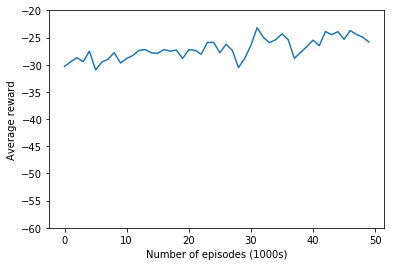

In [32]:
plt.plot(episode_reward_train[1:])
plt.xlabel("Number of episodes (1000s)")
plt.ylabel("Average reward")
plt.ylim(-60, -20)

tikz_save('hybrid_rewards.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


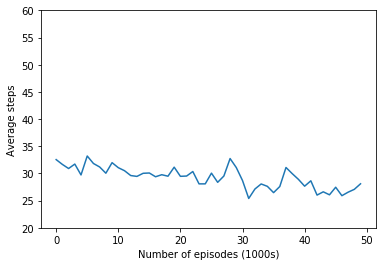

In [33]:
plt.plot(episode_length_train[1:])
plt.xlabel("Number of episodes (1000s)")
plt.ylabel("Average steps")
plt.ylim(20, 60)

tikz_save('hybrid_length.tikz', figureheight='\\figureheight', figurewidth='\\figurewidth')

In [47]:
def q_learning(env, estimator, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, train_phase=True):
    """
    Goes through the environment only once (stops when we reach a finishing state in the environment)
    """
    episode_length = 0
    episode_reward = 0
    updates = []
    
#     policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, actions)
#     Since we do not iterate over in q_learning, we do not have i_episode above. See if that is useful here and below (near end)
    policy = make_epsilon_greedy_policy(estimator, epsilon*epsilon_decay, actions)

    state = env.reset()

    while True:
        literal_clauseNum, clauseNum_clause, _ = env.state
        top_actions = policy(state, literal_clauseNum)
        action_literal_clauseNum = {l: literal_clauseNum[l] for l in top_actions}
        
        action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
        action_index = LIT_IDX[action]
        
#         action_index = np.random.choice(np.arange(len(action_prob)), p=action_prob)
#         action = REV_MAPPING[action_index]  # action is the literal now
        
#         action = 5
        _, reward, done = env.step(action)
        
        # Stats
        episode_length += 1
        episode_reward += reward

        if done:
            td_target = reward
            updates.append((state, td_target, action_index))
            break

        next_state = env.get_state()

        q_values = estimator.predict(next_state)
        td_target = reward + discount_factor * np.max(q_values)
        
        current_value = estimator.predict(state)[action_index]
        td_error = td_target - current_value
        
        alpha = 0.8
        update_target = current_value + alpha*td_error
        updates.append((state, td_target, action_index))
#         estimator.update(state, update_target, action_index)

        state = next_state

    return episode_reward, episode_length, estimator, updates


def q_learning_test(env, estimator, epsilon):
    episode_length = 0
    episode_reward = 0
    
    policy = make_epsilon_greedy_policy(estimator, epsilon, actions)

    state = env.reset()

    while True:
        literal_clauseNum, clauseNum_clause, _ = env.state
        top_actions = policy(state, literal_clauseNum)
        action_literal_clauseNum = {l: literal_clauseNum[l] for l in top_actions}
        
        action, _ = bohm(action_literal_clauseNum, clauseNum_clause)
        _, reward, done = env.step(action)
        
        # Stats
        episode_length += 1
        episode_reward += reward

        if done:
            break

        state = env.get_state()

    return episode_reward, episode_length

In [57]:
def train(training_files, epochs, ϵ):
    """
    One episode is one file. Each call to q_learning function does one episode only and returns. 
    An Env can be instantiated with one file only, so can only do one episode.
    
    In one epoch, you go through all the files in your training dataset.
    """
    epoch_reward, epoch_length, losses = [], [], []
    estimator = Estimator()
    
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0
        
        shuffle(training_files)  # Shuffles files in-place

        for j, filepath in enumerate(training_files):
            """ Each file in one episode """
            
#             if j % 10 == 0:
#                 print(j)
                
            env = Env(filepath)
            episode_reward, episode_length, estimator, updates = q_learning(env, estimator, epsilon=ϵ, epsilon_decay=0.95**i)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
            # Do a batch update at every file
            states, targets, action_idxs = zip(*updates)
            states, targets, action_idxs = np.array(states), np.array(targets), np.array(action_idxs)
#             set_trace()
            loss = estimator.update(states, targets, action_idxs)
            losses.append(np.mean(loss))
            
        # Average reward per episode in this epoch
        epoch_reward.append(curr_epoch_reward / len(training_files))

        # Average length of each episode in this epoch
        epoch_length.append(curr_epoch_length / len(training_files))
        
        print("Reward:", epoch_reward[-1])
        print("Length:", epoch_length[-1])
        print("Loss:", losses[-1])
            
    return epoch_reward, epoch_length, estimator


def test(test_files, epochs=10, ϵ=1.1, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    epoch_reward, epoch_length = [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1 
    
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0

        shuffle(test_files)
        
        for filepath in test_files:
            env = Env(filepath)
            episode_reward, episode_length = q_learning_test(env, estimator, ϵ)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
        # Average reward per training example in this epoch
        epoch_reward.append(curr_epoch_reward / len(test_files))

        # Average episode length per example in this epoch
        epoch_length.append(curr_epoch_length / len(test_files))
            
            
    return epoch_reward, epoch_length

In [61]:
# %%prun
import time

numVars = 20
LITERALS = list(range(-numVars, 0))
pos_lit = list(range(1, numVars+1))
LITERALS.extend(pos_lit)
LIT_IDX = {}  # Global mapping between literal and its position in the action space
IDX_LIT = {}  # Global mapping between its position in the action space and literal

for index, var in enumerate(LITERALS):
    LIT_IDX[str(var)] = index
    IDX_LIT[index] = str(var)

actions = len(LITERALS)  # Number of actions available to use by the agent
state_space = 4

directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))
shuffle(files)

split = int(len(files) * 0.2)
training_files = files[:split]
test_files = files[60000:61000]

# directory = '../Tests/SATLIB_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
# files = os.listdir(directory)
# files = list(map(lambda x: os.path.join(directory, x), files))
# split = int(len(files) * 1.0)
# test_files = files[split:split+int(len(files) * 0.01)] 

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))


episode_reward_train, episode_length_train, estimator = train(training_files, epochs=20, ϵ=0.2)
print("Done training")
print()

s = time.time()
episode_reward_test, episode_length_test = test(test_files, epochs=1, ϵ=0.1, estimator=estimator)
e = time.time()

print("Done testing in", (round(e-s, 2)), "s")
print()

# episode_reward_rand, episode_length_rand = test(test_files, epochs=2)
# print("Done testing random policy")

Number of training files: 800
Number of test files: 200
Epoch Number: 1


/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Reward: -5.2318665804217925
Length: 14.45625
Loss: 10.149142
Epoch Number: 2
Reward: -5.250265052972907
Length: 14.47625
Loss: 30.13606
Epoch Number: 3
Reward: -5.213989308049163
Length: 14.4375
Loss: 26.943102
Epoch Number: 4
Reward: -5.209802782615267
Length: 14.34625
Loss: 45.99311
Epoch Number: 5


KeyboardInterrupt: 

**TRAIN IN BATCHES**

In [35]:
%debug

> /home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/tensorflow/python/client/session.py(1336)_do_call()
   1334         except KeyError:
   1335           pass
-> 1336       raise type(e)(node_def, op, message)
   1337 
   1338   def _extend_graph(self):

ipdb> u
> /home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/tensorflow/python/client/session.py(1317)_do_run()
   1315     if handle is None:
   1316       return self._do_call(_run_fn, self._session, feeds, fetches, targets,
-> 1317                            options, run_metadata)
   1318     else:
   1319       return self._do_call(_prun_fn, self._session, handle, feeds, fetches)

ipdb> u
> /home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/tensorflow/python/client/session.py(1120)_run()
   1118     if final_fetches or final_targets or (handle and feed_dict_tensor):
   1119       results = self._do_run(handle, final_targets, final_fetches,
-> 1120                              feed_dict_tensor, options, 

ipdb> q


In [9]:
# with open('SATLIB_50_unit_reward.pickle', 'wb') as fout:
#         pickle.dump((episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand), fout)

# with open('SATLIB_50.pickle', 'rb') as fin:
#         episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand = pickle.load(fin)

Average reward for last 10 epochs in training: -5.266
Average reward for last 10 epochs in testing: -5.353


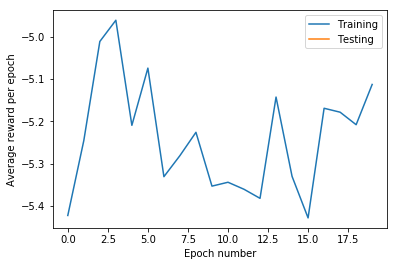

In [53]:
plt.plot(episode_reward_train, label='Training')
plt.plot(episode_reward_test, label='Testing')
# plt.plot(episode_reward_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average reward per epoch')
plt.legend()

last_n = 10
train_avg = np.mean(np.array(episode_reward_train)[-last_n:])
test_avg = np.mean(np.array(episode_reward_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_reward_rand)[-last_n:])

print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Average length for last 10 epochs in training: 14.399
Average length for last 10 epochs in testing: 14.695


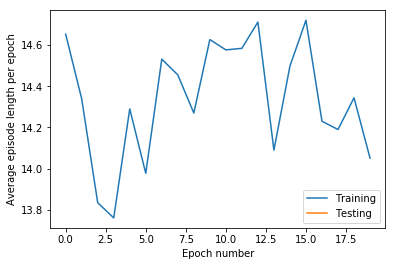

In [54]:
plt.plot(episode_length_train, label='Training')
plt.plot(episode_length_test, label='Testing')
# plt.plot(episode_length_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average episode length per epoch')
plt.legend()

train_avg = np.mean(np.array(episode_length_train)[-last_n:])
test_avg = np.mean(np.array(episode_length_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_length_rand)[-last_n:])

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Text(0,0.5,'Actions')

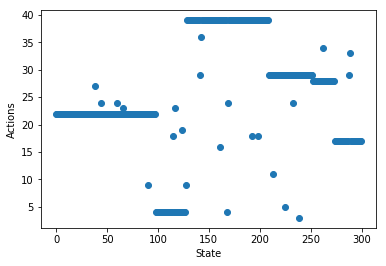

In [182]:
xs = range(300)

policy = make_epsilon_greedy_policy(estimator, 0.1, actions)
ys = [np.random.choice(np.arange(actions), p=policy(i, {l: set([0]) for l in range(-numVars, numVars+1)})) for i in xs]

plt.scatter(xs, ys)
plt.xlabel("State")
plt.ylabel("Actions")

In [183]:
state = 256

estimator.predict(state)

array([-1.08106339, -0.98628557, -1.00681334, -1.14676465, -1.01414276,
       -1.03920674, -0.95491733, -0.97960388, -1.11900149, -0.96197248,
       -0.98531593, -0.96607036, -1.0109629 , -0.97665428, -0.99197745,
       -1.00057868, -1.02822085, -0.95329277, -0.98146715, -0.98885396,
        0.        , -0.98633782, -1.04502484, -1.07116725, -0.95054096,
       -0.96212715, -1.0541073 , -1.00578894, -0.93820797, -0.95318104,
       -1.0228148 , -1.03815234, -0.97108546, -0.96719226, -1.02232722,
       -1.0172402 , -1.03255231, -1.05948592, -1.03425613, -1.0285922 ,
       -0.97348332])

Text(0,0.5,'Q-value')

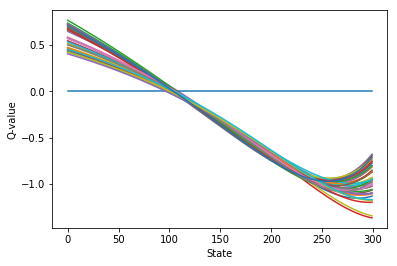

In [185]:
# plt.figure(figsize=(10, 12))

q_values = np.array([estimator.predict(s) for s in xs])

for i in range(actions):
    plt.plot(q_values[:, i], label='Action '+str(i))

# plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')

Testing time taken to use a heuristic

In [88]:
import time

heuristic = jw_2
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.1)
training_files = files[:split]

total_time = 0

for file in training_files:
    env = Env(file)
    env.reset()
    a, b, c = env.state
    
    s = time.time()
    for _ in range(1000):
        heuristic(a, b)
    e = time.time()
    total_time += (e - s) / 1000
    
print(total_time / split)

0.00011689195871353151


In [ ]:
{0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}